Pasin Piyavej, 6681187

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import bitstring

In [2]:
img_path = 'smaller_coverimg.jpg'
# img_path = 'coverimg.jpg'
img_array = cv2.imread(img_path, flags=cv2.IMREAD_COLOR)
# img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
# plt.imshow(img_rgb)

data = "supersecretinfo.txt"
hidden_data = open(data, "rb")
message = hidden_data.read().decode('utf-8')

## Introduction
In ancient Greece, steganography meant “secret writing.” A well-known method involved shaving a messenger’s head, writing the hidden message directly on the scalp, and waiting for the hair to grow back before sending the messenger out.

In the modern era, vast amounts of information are transmitted as digital signals. Adopting the same principle of concealing information where it is least expected, digital steganography embeds data within ordinary media, such as images. By exploiting specific embedding techniques, data can be hidden in ways that introduce changes too subtle for human vision to detect.

## Traditional Technique
The simplest way to illustrate the concept of steganography is through the Least Significant Bit (LSB) substitution technique. The hidden message is first converted into a sequence of bits. Then, for each pixel in the image, the least significant bit of a color channel is replaced with one bit of the message. Because this modification alters only a single bit, the visual impact is effectively undetectable to the human eye.

However, this method has a major weakness. When an image undergoes filtering, compression, or any process that removes or alters high-frequency components, the altered LSBs can be exposed or destroyed. As a result, differences between the original image and the steganographic image become easy to detect.

<center>
  <img src="resource/Original.png" height="300">
  <img src="../Presentation/resource/Original_filter.png" height="300">
  <img src="../Presentation/resource/Original_filter_after_lsb.png" height="300">
</center>

## Works of JPEG
The JPEG algorithm relies on a mathematical transformation based on the cosine function. The image is first divided into 8×8 blocks, and each block is independently processed. For every block, the 2-D Discrete Cosine Transform (DCT) is applied, converting spatial pixel values into a set of frequency coefficients.

Before the DCT is performed, each pixel value is shifted by −128 to center the data around zero, since JPEG assumes an input range of −128 to +127 rather than 0 to 255.

After the DCT, each coefficient is passed through a process called quantization. The coefficient is divided by a corresponding value in the JPEG luminance quantization table, which determines how strongly each frequency component is preserved. Low-frequency terms (top-left) are visually important, while high-frequency terms (bottom-right) represent fine details and are more easily discarded.

The quantized 8×8 block is then scanned in a zigzag pattern to group low-frequency components first and cluster long runs of zeros at the end. This sequence is finally encoded using Huffman coding to efficiently compress repeated values.

<center><img src="resource\JPEG luminance quantization table.png" width=800></center>

## Proposed Technique
Our proposed technique is based on the observation that JPEG compression messed up the original least significant bits, making traditional LSB-based steganography easy to detect. This property can instead be used as an advantage, it becomes more difficult for an external party to distinguish between normal compression artifacts and embedded data.

The key idea is to intervene within the JPEG compression pipeline itself, inserting the hidden data during or immediately before the Huffman coding stage. By embedding information after quantization and before entropy coding, the modifications blend into the natural statistical patterns of JPEG compression, reducing detectability.

<center>
  <img src="resource\jpg_8x8pattern.png" width = 200>
</center>

In [3]:
JPG_luminance_table = np.array([
# <---general brightness variations---
  [16, 11, 10, 16,  24, 40,   51,  61], # |
  [12, 12, 14, 19,  26, 58,   60,  55], # |
  [14, 13, 16, 24,  40, 57,   69,  56], # |
  [14, 17, 22, 29,  51, 87,   80,  62], # | fine details and sharp edges
  [18, 22, 37, 56,  68, 109, 103,  77], # |
  [24, 36, 55, 64,  81, 104, 113,  92], # | 
  [49, 64, 78, 87, 103, 121, 120, 101], # |
  [72, 92, 95, 98, 112, 100, 103,  99]  # \/
])

def slice_image_8x8(image):
  blocks = []
  for vertic_slice in np.vsplit(image, int(image.shape[0] / 8)):
    for horiz_slice in np.hsplit(vertic_slice, int(image.shape[1] / 8)):
      blocks.append(horiz_slice)
  return np.array(blocks)

<center>
  <img src="resource\Zig-zag-ordering-of-DCT-coefficients.png" height = 250>
  <img src="resource\The-zig-zag-sequence-of-DCT-coefficients.png" height = 250>
</center>

In [4]:
pre_computed_zigzag = np.array([
  (0,0), (0,1), (1,0), (2,0), (1,1), (0,2), (0,3), (1,2),
  (2,1), (3,0), (4,0), (3,1), (2,2), (1,3), (0,4), (0,5),
  (1,4), (2,3), (3,2), (4,1), (5,0), (6,0), (5,1), (4,2),
  (3,3), (2,4), (1,5), (0,6), (0,7), (1,6), (2,5), (3,4),
  (4,3), (5,2), (6,1), (7,0), (7,1), (6,2), (5,3), (4,4),
  (3,5), (2,6), (1,7), (2,7), (3,6), (4,5), (5,4), (6,3),
  (7,2), (7,3), (6,4), (5,5), (4,6), (3,7), (4,7), (5,6),
  (6,5), (7,4), (7,5), (6,6), (5,7), (6,7), (7,6), (7,7)
])

def zigzag(block) :
  return block[pre_computed_zigzag[:, 0], pre_computed_zigzag[:, 1]]

def inverse_zigzag(inputMat, row:int, col:int) :
  output = np.zeros((row, col))
  output[pre_computed_zigzag[:, 0], pre_computed_zigzag[:, 1]] = inputMat
  return output

In [5]:
def encode_stego(encoded_bits, dct_blocks):
  encoded_bits.pos = 0
  header = bitstring.pack('uint:32', len(encoded_bits))
  payload = header + encoded_bits
  payload.pos = 0
  total_bits = len(payload)

  converted_blocks = []
  complete = False

  for block_idx, block in enumerate(dct_blocks):
    block = np.array(block, dtype=np.float32)

    for i in range(1, len(block)):
      if payload.pos >= total_bits:
        complete = True
        break

      coeff = int(block[i])
      if coeff > 1:
        packed = bitstring.pack('uint:8', np.uint8(coeff))
        packed[-1] = payload.read(1)
        block[i] = float(packed.read('uint:8'))

    converted_blocks.append(block)

    if complete:
      for rest_block in dct_blocks[block_idx + 1:]:
        converted_blocks.append(np.array(rest_block, dtype=np.float32))
      break

  if not complete:
    raise ValueError("Data didn't fully embed")

  return converted_blocks

def construct_stego(block_width, block_segments):
  image_rows = []
  temp = []
  for i in range(len(block_segments)):
    if i > 0 and not(i % int(block_width / 8)):
      image_rows.append(temp)
      temp = [block_segments[i]]
    else:
      temp.append(block_segments[i])
  image_rows.append(temp)

  return np.block(image_rows)

def extract_stego(dct_blocks):
  bits = bitstring.BitStream()
  for current_dct_block in dct_blocks:
    for i in range(1, len(current_dct_block)):
      coeff = int(current_dct_block[i])
      if coeff > 1:
        lsb = np.uint8(coeff) & 0x01
        bits.append(f'uint:1={lsb}')
  return bits

def cal_peaksnr(img1, img2):
  SNR = np.mean((img1 - img2) ** 2)
  if SNR == 0:
    return float('inf')
  max_pixel = 255.
  peak_snr = 10 * np.log10((max_pixel ** 2) / SNR)
  return peak_snr

In [6]:
img_path = 'coverimg.jpg'
img_array = cv2.imread(img_path, flags=cv2.IMREAD_COLOR)

data = "supersecretinfo.txt"
with open(data, "rb") as f:
  message = f.read().decode('utf-8')

height, width = img_array.shape[:2]

float_padded = np.float32(img_array)
blocks = slice_image_8x8(float_padded)
stego_image = np.empty_like(float_padded)

## To Futher Optimize the technique
To improve resistance against detection, the technique can be extended by modifying the JPEG luminance quantization table. By applying gradient descent, it is possible to search for an optimal scaling factor that minimizes visible distortion while adjusting the relative weighting of frequency components. This modification reduces noise and improves concealment.

Moreover, standard JPEG luminance tables are publicly known. If the original table is used, an analyst could potentially reconstruct or extract hidden information. By rescaling or altering the table, the original quantization pattern becomes unusable for decryption. Anyone attempting to recover the embedded data must first know the exact scaling parameters used, which introduces an additional security layer.

<center>
  <img src="resource\DCT Quatization Matrix.webp" height = 250>
</center>

#Iterated: 0
Peak SNR: 42.57641 Scale to 0.9984698600770947
#Iterated: 1
Peak SNR: 42.63815 Scale to 0.99515767330134
#Iterated: 2
Peak SNR: 42.746857 Scale to 0.9912643764504817
#Iterated: 3
Peak SNR: 42.830513 Scale to 0.9853546611705134
#Iterated: 4
Peak SNR: 42.592857 Scale to 0.9964392148013527
#Iterated: 5
Peak SNR: 42.718792 Scale to 0.9922819309520896
#Iterated: 6
Peak SNR: 42.81448 Scale to 0.9863046664324514
#Iterated: 7
Peak SNR: 42.564198 Scale to 0.9989083368462932
#Iterated: 8
Peak SNR: 42.593124 Scale to 0.9964601740989625
#Iterated: 9
Peak SNR: 42.71851 Scale to 0.9923032914212268
#Iterated: 10
Peak SNR: 42.81347 Scale to 0.9863744130465374
#Iterated: 11
Peak SNR: 42.55694 Scale to 0.9990558855679182
#Iterated: 12
Peak SNR: 42.586597 Scale to 0.9966505926567734
#Iterated: 13
Peak SNR: 42.70529 Scale to 0.9925199221825952
#Iterated: 14
Peak SNR: 42.812637 Scale to 0.9863942206134101
#Iterated: 15
Peak SNR: 42.557026 Scale to 0.9990720916667086
#Iterated: 16
Peak SNR: 42.

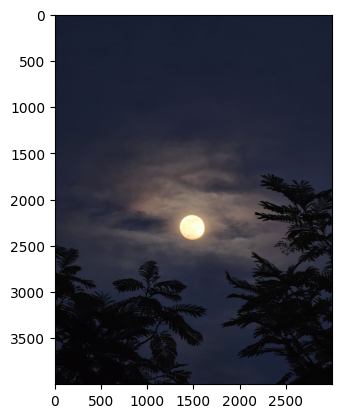

In [7]:
lum_scale_level = 1.0
learning_rate = 0.001
psnr = []
scaled = []
images = []
max_iterate = 20

def dct_stego(lum_scale_level=1.0):
  scaled_lum_table = JPG_luminance_table * lum_scale_level
  for channel in range(3):
    channel_blocks = blocks[..., channel]
    dct_blocks = np.array([cv2.dct(block) for block in channel_blocks])

    dct_quan = np.array([(block / scaled_lum_table).astype(np.float32) for block in dct_blocks])
    dct_quantize_int = np.round(dct_quan)

    sorted_coefficients = [zigzag(mat) for mat in dct_quantize_int]
    if channel == 0:
      ascii_bytes = message.encode('ascii')
      bits = bitstring.BitStream()
      for byte in ascii_bytes:
        bits.append(f'uint:8={byte}')
      embedded_dct_blocks = encode_stego(bits, sorted_coefficients)
      coeffs_to_use = embedded_dct_blocks
    else:
      coeffs_to_use = sorted_coefficients

    desorted_coefficients = [inverse_zigzag(block, 8, 8) for block in coeffs_to_use]
    dct_dequants = [coef * scaled_lum_table for coef in desorted_coefficients]
    idct_blocks = [cv2.idct(block.astype(np.float32)) for block in dct_dequants]

    stego_image[:, :, channel] = construct_stego(width, idct_blocks)

  return np.uint8(np.clip(stego_image, 0, 255))

def central_diff(f, scale_level):
  h = 0.01
  backword_sub = f(scale_level - h)
  forword_sub = f(scale_level + h)
  psnr_minus = cal_peaksnr(backword_sub, img_array)
  psnr_plus = cal_peaksnr(forword_sub, img_array)
  return (psnr_plus - psnr_minus) / (2 * h)

for i in range(max_iterate):
  gradient = central_diff(dct_stego, lum_scale_level)
  lum_scale_level -= learning_rate * gradient

  current_img = dct_stego(lum_scale_level)
  current_psnr = cal_peaksnr(current_img.astype(np.float32), img_array)
  psnr.append(current_psnr)
  images.append(current_img)
  scaled.append(lum_scale_level)
  
  print("#Iterated:", i)
  print("Peak SNR:", current_psnr, "Scale to", lum_scale_level)

  if len(psnr) >= 4 and abs(psnr[-1] - psnr[-2]) < 0.01:
    break

best_idx = np.argmax(psnr)
val_clip = images[best_idx]

print("\nFinal value; Peak SNR:", psnr[best_idx], "LUM scale to", scaled[best_idx])
plt.imshow(cv2.cvtColor(val_clip, cv2.COLOR_BGR2RGB))
cv2.imwrite("./stegoimg.png", val_clip)
print(len(message), "characters saved")

In [8]:
stego_image = cv2.imread("./stegoimg.png", flags=cv2.IMREAD_COLOR)
stego_image_float = np.float32(stego_image)
stego_blocks = slice_image_8x8(stego_image_float)
stego_chan = np.array([block[:, :, 0] for block in stego_blocks])

scaled_lum = JPG_luminance_table * lum_scale_level
dct_blocks = [cv2.dct(block.astype(np.float32)) for block in stego_chan]
dct_quants = [block / scaled_lum for block in dct_blocks]
dct_quants_int = [np.round(q) for q in dct_quants]

zigzag_blocks = [zigzag(q) for q in dct_quants_int]
recovered_data = extract_stego(zigzag_blocks)
total_bits = len(recovered_data)

if total_bits < 32:
  print("Invalid Format")
else:
  recovered_data.pos = 0
  length_bits = recovered_data.read('uint:32')
  available_bits = total_bits - 32

  usable_bits = min(length_bits, available_bits)
  usable_bits -= usable_bits % 8
  data_len = usable_bits // 8
  
  buf = bytearray()
  for _ in range(data_len):
    buf.append(recovered_data.read('uint:8'))

  secret = bytes(buf).decode('ascii', errors='replace')
  print(len(secret), "characters read")
  print("Message read:")
  print(secret)

1901 characters read
Message read:
The basic intuition behind gradient descent can be illustrated by a hypothetical scenario. People are stuck in the mountains and are trying to get down (i.e., trying to find the global minimum). There is heavy fog such that visibility is extremely low. Therefore, the path down the mountain is not visible, so they must use local information to find the minimum. They can use the method of gradient descent, which involves looking at the steepness of the hill at their current�posiTion, then procee$ing in the direction wiD` the steepest descent (i.e., downhill). If they were trying to find the top of the mountain (i.e., the maximum), then they would proceed iF the direction of steepest ascent (i.e., uphill). Using this method, they would eventually find their way down the mountain or possibly get stuck in some hole (i.e., local minimum or saddle point), like a mountain lake. However, assume also that the steepness of the hill is not immediately obvious wit

## Measurement Metrics
To evaluate the effectiveness of the technique, Peak Signal-to-Noise Ratio (PSNR) can be used. PSNR measures the difference between the steganographic image and the original image. A higher PSNR value indicates that the two images are very similar and that the embedding process introduces minimal distortion.

When visualizing the difference, darker regions indicate smaller differences, meaning the steganographic image remains closer to the original. This corresponds to better concealment, since the color deviation approaches zero.

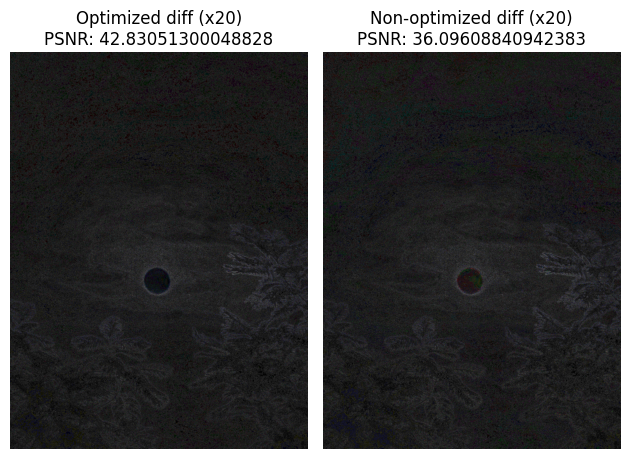

In [9]:
orig  = cv2.imread("coverimg.jpg").astype(np.float32)
stego_optimize = cv2.imread("stegoimg.png").astype(np.float32)
stego_non_opti = dct_stego()

amplify = 20
fig, axs = plt.subplots(1, 2)

diff_optimize = np.abs(stego_optimize - orig)
vis = np.clip(diff_optimize * amplify, 0, 255).astype(np.uint8)
psnr_optimized = cal_peaksnr(stego_optimize, orig)
axs[0].imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
axs[0].set_title(f"Optimized diff (x20)\nPSNR: {psnr_optimized}")
axs[0].axis('off')

diff_non_opti = np.abs(stego_non_opti.astype(np.float32) - orig)
vis = np.clip(diff_non_opti * amplify, 0, 255).astype(np.uint8)
psnr_non_optimized = cal_peaksnr(stego_non_opti.astype(np.float32), orig)
axs[1].imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
axs[1].set_title(f"Non-optimized diff (x20)\nPSNR: {psnr_non_optimized}")
axs[1].axis('off')

plt.tight_layout()
plt.show()